<a href="https://colab.research.google.com/github/dhruvmhjn/stat_sig/blob/main/Statsig_Workshop_P%26G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statsig Experimentation 201

**Please make a copy of this notebook** for your own use. This is read-only and your changes to this copy will be lost.

This notebook, and its partner with B2B data [here](https://colab.research.google.com/drive/1wI074_sp4dCKbvN0xZX4x5Z1KL96ikAS?usp=sharing), have boilerplate code and functions for running common experimentation procedures to clean data and reduce variance.

There's a variety of functions here which integrate with the provided example datasets. You should be able to run the notebook end to end, and comment out the adjustments in the final analysis to understand the impact of different procedures.

Refer to the collapsed function code to dig into and adjust the procedures! During sessions with Statsig, we'll discuss potential adjustments and see what we can come up with together.

Feel free to use this as a reference or copy code as needed for your own usage. We do ask that you credit Statsig if using this for publications, including blogs.



## Setup

In [ ]:
import pandas as pd
import uuid
import random
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import ttest_ind_from_stats, ttest_ind, t, norm, binom

In [ ]:
class DataSets:
  _cache = {}

  @classmethod
  @property
  # Dataset with pre and post exposure purchases and revenue data -
  # standard dataset for digging into dealing with cuped, etc.
  def revenue(self):
    return self.get_dataset('revenue')

  @classmethod
  @property
  # Dataset with a segmented b2b a-a test for evaluating stratification
  # efficacy
  def b2b_aa(self):
    return self.get_dataset('b2b')

  @classmethod
  @property
  # Dataset with extreme outliers
  def outliers(self):
    return self.get_dataset('outliers')

  @classmethod
  def get_dataset(self, dataset_name):
    if dataset_name not in self._cache:
      print(f"Downloading {dataset_name}...")
      self._cache[dataset_name] = pd.read_csv(self.dataset_url(dataset_name))
    else:
      print(f"Using cached values for {dataset_name}...")
    return self._cache[dataset_name]

  @classmethod
  def dataset_url(self, dataset_name):
    urls = {
        'revenue': 'https://drive.google.com/uc?id=1b9n63pTQUhKXMuxtv_cwtmOujRnCF4ur',
        'outliers': 'https://drive.google.com/uc?id=1rvZSUcQUecTjpeJF9DHVE3mZD_G7aAFK',
        'b2b': 'https://drive.google.com/uc?id=1ulpokdnnkRzGUp4CxQ2b-wuj1zTuU7vZ',
    }
    return urls[dataset_name]


## Dataset Selection

In [ ]:
raw_data = DataSets.revenue # A dataset tracking user revenue
# raw_data = DataSets.outliers # Revenue dataset, but with outliers due to fraud

print("Columns are:")
for column in list(raw_data.columns):
  print("-", column)

analysis_field = 'total_revenue'
# analysis_field = 'purchases'


Columns are:
- unit_id
- group
- exposure_time
- days_exposed
- region
- income_bracket
- purchases
- purchases_pre_experiment
- total_revenue
- total_revenue_pre_experiment


In [ ]:
print(f"""
  Data Profile:
    Records: {raw_data.shape[0]}
    Mean: {np.mean(raw_data[analysis_field]):.2f}
    Max: {np.max(raw_data[analysis_field]):.2f}
    Min: {np.min(raw_data[analysis_field]):.2f}
    Standard Deviation: {np.std(raw_data[analysis_field]):.2f}
    Variance: {np.var(raw_data[analysis_field]):.2f}
""")


  Data Profile:
    Records: 20000
    Mean: 436.90
    Max: 3086.35
    Min: 0.00
    Standard Deviation: 405.44
    Variance: 164381.04



# Function Definitions

In [ ]:
def summarize_procedure(df, new_df, name, column='total_revenue'):
  print(f"""Applied {name}
    Overall dataset mean {np.mean(df[column]):.2f} -> {np.mean(new_df[column]):.2f}
    Overall dataset std {np.std(df[column]):.2f} -> {np.std(new_df[column]):.2f}
  """)

## Threshold-Based Metrics

In [ ]:
# Example metric transformation for variance reduction

def apply_threshold_metric(df, threshold, column='total_revenue'):
  new_df = df.copy()
  new_df[column] = new_df[column].apply(lambda x: 1 if x > threshold else 0)
  summarize_procedure(df, new_df, 'Threshold Transformation')
  return new_df

## Winsorization / Capping

In [ ]:
# Example Capping procedure.
# Note that this is typically done at the unit-day level; here we do it for the
# full duration for simplicity's sake. The consequence is that
# users with longer enrollment times will be capped more aggressively

def apply_capping(df, cap, column='total_revenue'):
  # where x is an np array and cap is a float
  new_df = df.copy()
  new_df[column] = new_df[column].apply(lambda x: cap if x > cap else x)
  summarize_procedure(df, new_df, 'Capping')
  return new_df



In [ ]:
# Winsorization procedure

def apply_winsorization(df, percentile=0.999, column='total_revenue'):
  new_df = df.copy()
  # Find cap. Note this is across both groups.
  cap = np.percentile(df[column], percentile*100, axis=0)
  print(f"Winsorization threshold is {cap}")
  # cap the variable at the value associated winsorization threshold percentile
  new_df[column] = new_df[column].apply(lambda x: cap if x > cap else x)
  summarize_procedure(df, new_df, 'Winsorization')
  return new_df


## CUPED Adjustment

In [ ]:
# Implements the most basic OLS form of CUPED
# The covariate MUST be orthogonal to experiment assignment. Recommend
# Only using pre-experiment data, or attributes collected previous to the time
# of assignment

# Expected input is an input dataframe with unit-level data summarized for
# Both the pre and post period
def apply_cuped(input_df,
                value_column='total_revenue',
                value_column_covariate='total_revenue_pre_experiment',
                verbose=False):
  df = input_df.copy()
  covariate = df[value_column_covariate]
  observed = df[value_column]
  covariance = np.cov(observed, covariate)[0, 1]
  variance_covariate = np.var(covariate)
  theta = covariance / variance_covariate # form of a centered OLS regression
  mean_observed = np.mean(observed)
  mean_covariate = np.mean(covariate)
  df[value_column] = df[value_column] - theta * (df[value_column_covariate] - mean_covariate)

  if(verbose):
    print(f"""CUPED Inputs:
      covariance: {covariance}
      theta (regression slope): {theta}
    """)
    plt.figure(figsize=(10, 4))
    plt.scatter(covariate - mean_covariate, observed - mean_observed, alpha=0.5)
    plt.xlabel('Total Value Pre-Exposure [demeaned]')
    plt.ylabel('Total Value Post-Exposure [demeaned]')
    plt.title('CUPED Regression')
    plt.grid(True)
    x_line = np.linspace(min(covariate - mean_covariate), max(covariate - mean_covariate), 100)
    y_line = theta * (x_line)
    plt.plot(x_line, y_line, color="red", label="Regression Line", linewidth=2)
    plt.scatter([mean_covariate], [mean_observed], label="Original Mean Value",
                marker="o", color="orange", s=40)
    plt.scatter([0], [0], label="Demeaned Mean (0, 0)", marker="x",
                color="purple", s=40)
    plt.legend()
    plt.show()

    summarize_procedure(input_df, df, 'CUPED')

  return df


# Adjustments & Results

## Adjustments

In [ ]:
# Keep a copy of the OG data to understand the impact of our changes
adjusted_data = raw_data.copy()

# adjusted_data = apply_capping(adjusted_data, 1000)
# adjusted_data = apply_winsorization(adjusted_data, 0.99)
# adjusted_data = apply_threshold_metric(adjusted_data, 100)
# adjusted_data = apply_cuped(adjusted_data, verbose=True) # Let's chat about easy improvements here

## Results

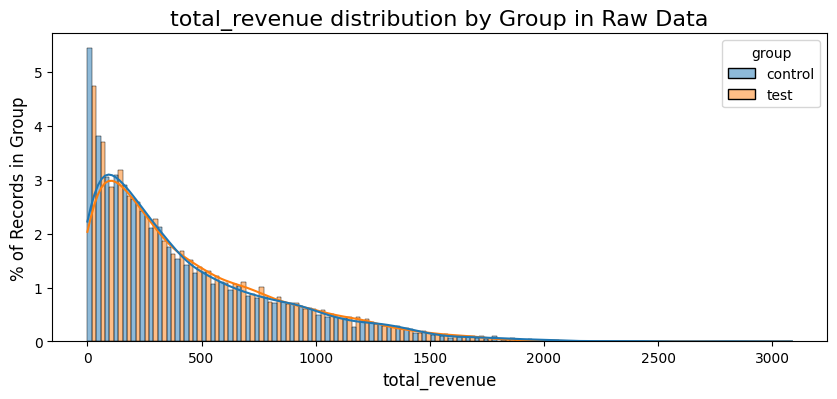

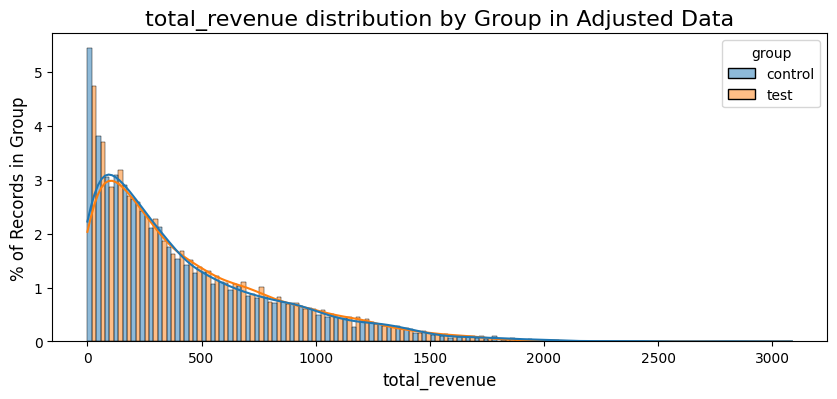

In [ ]:
plt.figure(figsize=(10, 4))  # Set the figure size to 10x5

sns.histplot(data=raw_data, x=analysis_field, hue="group",
             multiple="dodge", stat='percent', kde=1)
plt.title(f"{analysis_field} distribution by Group in Raw Data", fontsize=16)
plt.xlabel(analysis_field, fontsize=12)
plt.ylabel("% of Records in Group", fontsize=12)
# plt.xlim(np.min(raw_data[analysis_field]),np.max(raw_data[analysis_field]))
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(data=adjusted_data, x=analysis_field, hue="group",
             multiple="dodge", stat='percent', kde=1)
plt.title(f"{analysis_field} distribution by Group in Adjusted Data", fontsize=16)
plt.xlabel(analysis_field, fontsize=12)
plt.ylabel("% of Records in Group", fontsize=12)
# plt.xlim(np.min(raw_data[analysis_field]),np.max(raw_data[analysis_field]))
plt.show()

In [ ]:
results_raw = ttest_ind(
  raw_data[raw_data['group'] == 'test']['total_revenue'],
  raw_data[raw_data['group'] == 'control']['total_revenue']
)

results_adjusted = ttest_ind(
  adjusted_data[adjusted_data['group'] == 'test']['total_revenue'],
  adjusted_data[adjusted_data['group'] == 'control']['total_revenue']
)

alpha = 0.05

print(f"""
  p-value:
    Raw: {results_raw.pvalue:.4g}
    Adjusted: {results_adjusted.pvalue:.4g}
  Conclusion:
    Raw: {"Reject Ho" if results_raw.pvalue < alpha else "Fail to reject Ho"} with a p-value of {results_raw.pvalue:.3f} at significance = {alpha}
    Adjusted: {"Reject Ho" if results_adjusted.pvalue < alpha else "Fail to reject Ho"} with a p-value of {results_adjusted.pvalue:.3f} at significance = {alpha}
""")


  p-value:
    Raw: 0.1059
    Adjusted: 0.1059
  Conclusion:
    Raw: Fail to reject Ho with a p-value of 0.106 at significance = 0.05
    Adjusted: Fail to reject Ho with a p-value of 0.106 at significance = 0.05



# Advanced: A/A Testing

AA Testing is running a test with no intervention to make sure the  test behaves as expected under the null hypothesis,
generally meaning evaluating the false positive rate.

This can be done at the assignment level to make sure there's not issues with the assignment service,
or on analysis to evaluate the stats engine. For the latter, we can just shuffle assignments




Running AA test for Raw
4.2% of results were statistically significant false positives



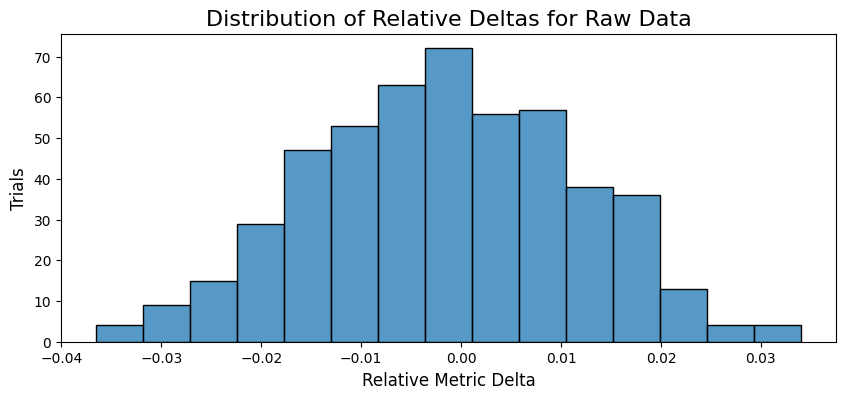



Running AA test for Adjusted
4.6% of results were statistically significant false positives



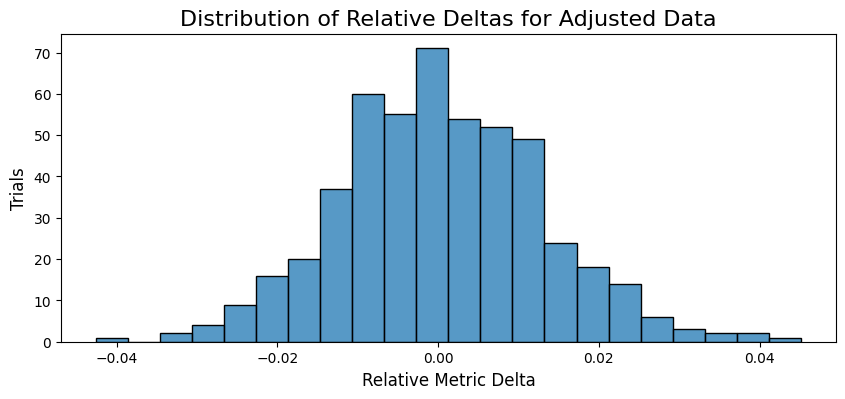

In [ ]:
print("AA Testing is running a test with no intervention to make sure the "+\
      " test behaves as expected under the null hypothesis,\n"+\
      "generally meaning evaluating the false positive rate.\n")
print("This can be done at the assignment level to make sure there's not "+\
      "issues with the assignment service,\nor on analysis to evaluate the "+\
      "stats engine. For the latter, we can just shuffle assignments\n\n")

def run_aa_test(df, outcome_column, unit_column, name, trials=500):
  print(f"\n\nRunning AA test for {name}")
  df_s = df.copy()

  deltas = []
  p_values = []

  for i in range(trials):
    salt = str(uuid.uuid4())
    df_s['group'] = df_s[unit_column]\
      .apply(lambda x: 'test' if abs(hash(salt + x)) % 2 == 0 else 'control')

    rt = df_s[df_s['group'] == 'test'][outcome_column]
    rc = df_s[df_s['group'] == 'control'][outcome_column]

    deltas.append((np.mean(rt) - np.mean(rc)) / np.mean(rc))
    p_values.append(ttest_ind(rt, rc).pvalue)

  print(f"{100*len([p for p in p_values if p < 0.05])/len(p_values)}% of results were statistically significant false positives\n")

  plt.figure(figsize=(10, 4))
  sns.histplot(deltas)
  plt.title(f"Distribution of Relative Deltas for {name} Data", fontsize=16)
  plt.xlabel("Relative Metric Delta", fontsize=12)
  plt.ylabel("Trials", fontsize=12)
  plt.show()

run_aa_test(raw_data, analysis_field, 'unit_id', 'Raw')
run_aa_test(adjusted_data, analysis_field, 'unit_id', 'Adjusted')


# Advanced: Heterogenous Effects

In [ ]:
# HTE

def pval_dim_vs_rest(dim_control_participating_units, dim_test_participating_units, dim_control_mean, dim_test_mean, dim_control_sdev, dim_test_sdev,
                        rest_control_participating_units, rest_test_participating_units, rest_control_mean, rest_test_mean, rest_control_sdev, rest_test_sdev):
  # ok so I know the inputs look crazy, but I promise that these are all things we know when we're looking at experiment results sliced by a 0/1 dimension

  # avg treatment effect is difference between test and control means
  ate_dim = dim_test_mean - dim_control_mean

  # variance of treatment effects or VAR(TE_test - TE_control) = VAR(TE_test) + VAR(TE_control)
  varte_dim = dim_test_sdev**2 + dim_control_sdev**2

  # n for TE is the n of the smaller group
  n_dim = min(dim_test_participating_units, dim_control_participating_units)

  # same methodology for rest
  ate_rest = rest_test_mean - rest_control_mean
  varte_rest = rest_test_sdev**2 + rest_control_sdev**2
  n_rest = min(rest_test_participating_units, rest_control_participating_units)

  # get degrees of freedom
  dof_num = (varte_rest/n_rest + varte_dim/n_dim)**2
  dof_denom = (varte_rest/n_rest)**2/(n_rest-1) + (varte_dim/n_dim)**2/(n_dim-1)
  hte_dof = dof_num/dof_denom

  # get standard deviation of the difference between dim vs the rest
  diff_sdev = (varte_rest/n_rest + varte_dim/n_dim)**0.5

  # get p-value
  welch_cdf_input = -abs((ate_rest - ate_dim) / diff_sdev)
  # use welch dist because doesn't assume equal sample size or variance
  welch_dist = t(df=hte_dof)
  p_val = welch_dist.cdf(welch_cdf_input) * 2

  return p_val

In [ ]:
df = raw_data.copy()

eg_dim_control_participating_units = len(df[(df['group'] == 'control') & (df['income_bracket'] == "HIGH")]['total_revenue'])*4
eg_dim_test_participating_units = len(df[(df['group'] == 'test') & (df['income_bracket'] == "HIGH")]['total_revenue'])*4
eg_dim_control_mean = np.mean(df[(df['group'] == 'control') & (df['income_bracket'] == "HIGH")]['total_revenue'])
eg_dim_test_mean = np.mean(df[(df['group'] == 'test') & (df['income_bracket'] == "HIGH")]['total_revenue'])
eg_dim_control_sdev = np.std(df[(df['group'] == 'control') & (df['income_bracket'] == "HIGH")]['total_revenue'])
eg_dim_test_sdev = np.std(df[(df['group'] == 'test') & (df['income_bracket'] == "HIGH")]['total_revenue'])
eg_rest_control_participating_units = len(df[(df['group'] == 'control') & (df['income_bracket'] != "HIGH")]['total_revenue'])
eg_rest_test_participating_units = len(df[(df['group'] == 'test') & (df['income_bracket'] != "HIGH")]['total_revenue'])
eg_rest_control_mean = np.mean(df[(df['group'] == 'control') & (df['income_bracket'] != "HIGH")]['total_revenue'])
eg_rest_test_mean = np.mean(df[(df['group'] == 'test') & (df['income_bracket'] != "HIGH")]['total_revenue'])
eg_rest_control_sdev = np.std(df[(df['group'] == 'control') & (df['income_bracket'] != "HIGH")]['total_revenue'])
eg_rest_test_sdev = np.std(df[(df['group'] == 'test') & (df['income_bracket'] != "HIGH")]['total_revenue'])

print(f"""
p-value for the hypothesis that ATE for High and Non-High segments are equal:
    {pval_dim_vs_rest(
        eg_dim_control_participating_units,
        eg_dim_test_participating_units,
        eg_dim_control_mean,
        eg_dim_test_mean,
        eg_dim_control_sdev,
        eg_dim_test_sdev,
        eg_rest_control_participating_units,
        eg_rest_test_participating_units,
        eg_rest_control_mean,
        eg_rest_test_mean,
        eg_rest_control_sdev,
        eg_rest_test_sdev)}
""")


p-value for the hypothesis that ATE for High and Non-High segments are equal:
    2.508192831380817e-10



Visualization for SOI: Distributions + Means


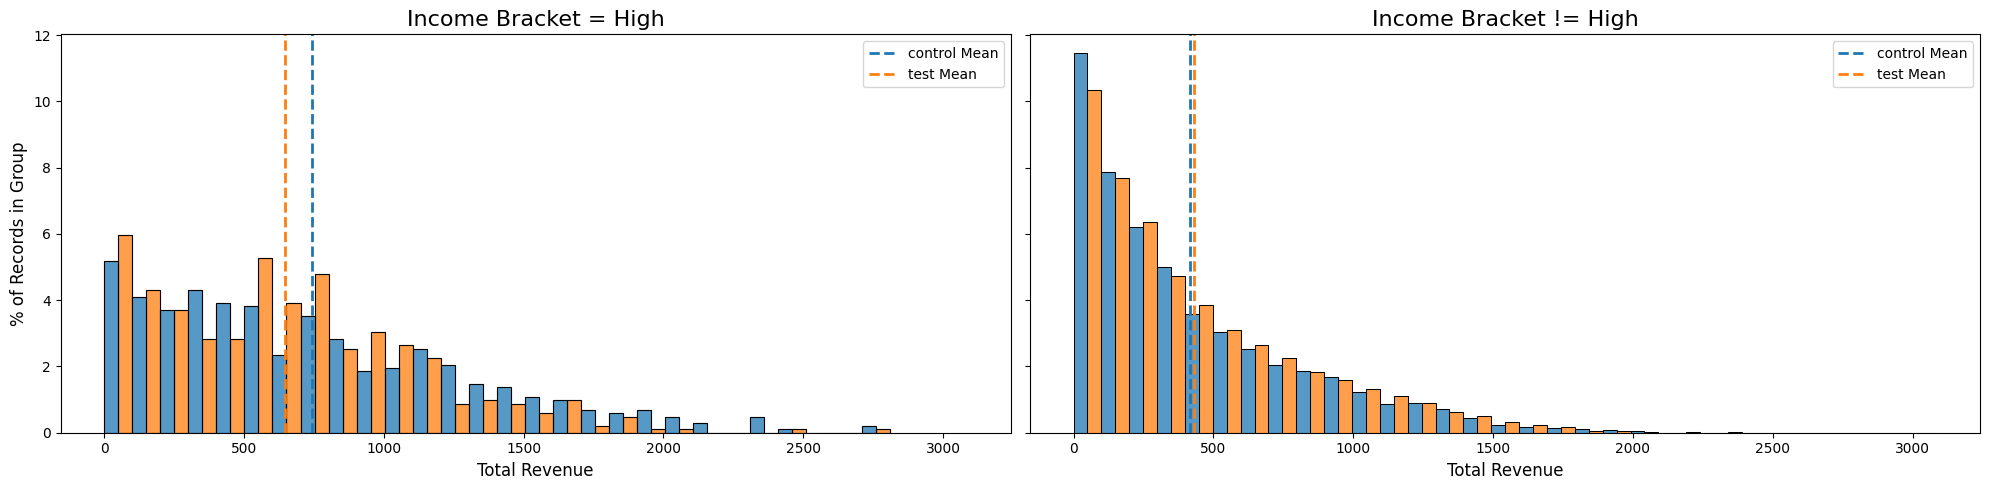

In [ ]:
# subplots with the same axes, but separate histograms for high income vs rest
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)

print("Visualization for SOI: Distributions + Means")

# income bracket = high
data1 = df[df['income_bracket'] == "HIGH"]
sns.histplot(
    data=data1,
    x="total_revenue",
    hue="group",
    multiple="dodge",
    stat='percent',
    ax=axes[0],
    binwidth=100
)

# vertical lines for ate viz
for group in data1['group'].unique():
    mean_value = data1[data1['group'] == group]['total_revenue'].mean()
    color = sns.color_palette()[data1['group'].unique().tolist().index(group)]
    axes[0].axvline(mean_value, color=color, linestyle='--', linewidth=2, label=f'{group} Mean')
axes[0].set_title("Income Bracket = High", fontsize=16)
axes[0].set_xlabel("Total Revenue", fontsize=12)
axes[0].set_ylabel("% of Records in Group", fontsize=12)
axes[0].legend()

# income bracket != high
data2 = df[df['income_bracket'] != "HIGH"]
sns.histplot(
    data=data2,
    x="total_revenue",
    hue="group",
    multiple="dodge",
    stat='percent',
    ax=axes[1],
    binwidth=100
)

# vertical lines for ate viz
for group in data2['group'].unique():
    mean_value = data2[data2['group'] == group]['total_revenue'].mean()
    color = sns.color_palette()[data2['group'].unique().tolist().index(group)]
    axes[1].axvline(mean_value, color=color, linestyle='--', linewidth=2, label=f'{group} Mean')
axes[1].set_title("Income Bracket != High", fontsize=16)
axes[1].set_xlabel("Total Revenue", fontsize=12)
axes[1].set_ylabel("% of Records in Group", fontsize=12)
axes[1].legend()


plt.tight_layout()
plt.show()

# Advanced: Stratified Sampling (Salt Selection)

In [ ]:
# For salt selection we're going to focus on the b2b use case

b2b = DataSets.b2b_aa
for column in list(b2b.columns):
  print("-", column)


- company_id
- group
- segment
- days_exposed
- total_revenue


In [ ]:
results = ttest_ind(
  b2b[b2b['group'] == 'test']['total_revenue'],
  b2b[b2b['group'] == 'control']['total_revenue']
)

alpha = 0.05

print(f"""
  p-value: {results.pvalue:.4g}
  conclusion: {"Reject Ho" if results.pvalue < alpha else "Fail to reject Ho"} with a p-value of {round(results.pvalue, 3)} at significance = {alpha}
""")


  p-value: 0.04918
  conclusion: Reject Ho with a p-value of 0.049 at significance = 0.05



In [ ]:
print("Is this dataset problematic?\n\n")
b2b.groupby(['group', 'segment']).agg(
    records=('total_revenue', 'count'),
    total_revenue=('total_revenue', 'sum'),
    avg_revenue=('total_revenue', 'mean')
).reset_index()

Is this dataset problematic?




,group,segment,records,total_revenue,avg_revenue
0,control,HEAD,1,9.438915e+05,9.438915e+05
1,control,TAIL,212,2.145098e+06,1.011839e+04
2,control,TORSO,37,3.713347e+06,1.003607e+05
3,test,HEAD,5,6.623456e+06,1.324691e+06
4,test,TAIL,205,2.211951e+06,1.079000e+04
5,test,TORSO,40,4.249317e+06,1.062329e+05


In [ ]:
print("This data was an AA test - group selection has no bearing on data output.")
print("The result was driven by an imbalance of assignments in the head segment.")
print("This fairly extreme result isn't all that rare!")

n = b2b[b2b.segment == 'HEAD'].shape[0]
n_1 = b2b[(b2b.segment == 'HEAD') & (b2b.group == 'control')].shape[0]
n_2 = b2b[(b2b.segment == 'HEAD') & (b2b.group == 'test')].shape[0]
h = max(n_1, n_2)
l = min(n_1, n_2)

p = 0.5

if h == l:
  intersection = binom.cdf(h, n, p) - binom.cdf(h-1, n, p)
else:
  intersection = 0


probability_1 = 1 - binom.cdf(h-1, n, p)
probability_2 = binom.cdf(l, n, p)
overall = probability_1 + probability_2 - intersection

print(f"""
  Probability of either group getting this extreme of an imbalance: {overall:.4g}
""")

This data was an AA test - group selection has no bearing on data output.
The result was driven by an imbalance of assignments in the head segment.
This fairly extreme result isn't all that rare!

  Probability of either group getting this extreme of an imbalance: 0.2188



AA test with b2b data


Running AA test for B2B
4.0% of results were statistically significant false positives



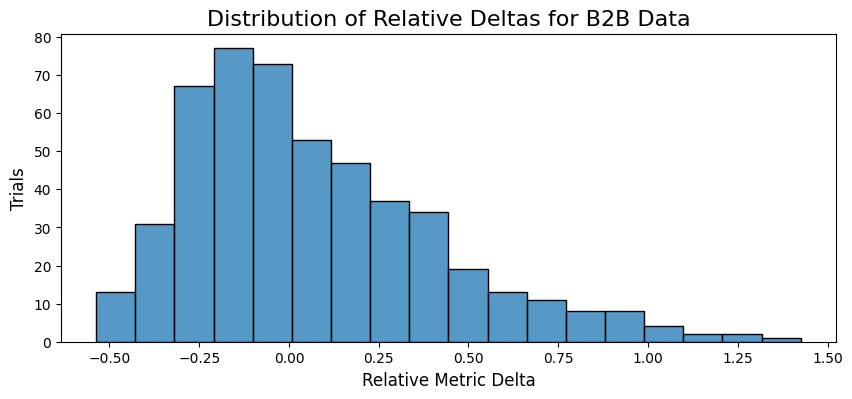

In [ ]:
print("AA test with b2b data")
run_aa_test(b2b, 'total_revenue', 'company_id', 'B2B')

0.0% of results were statistically significant false positives




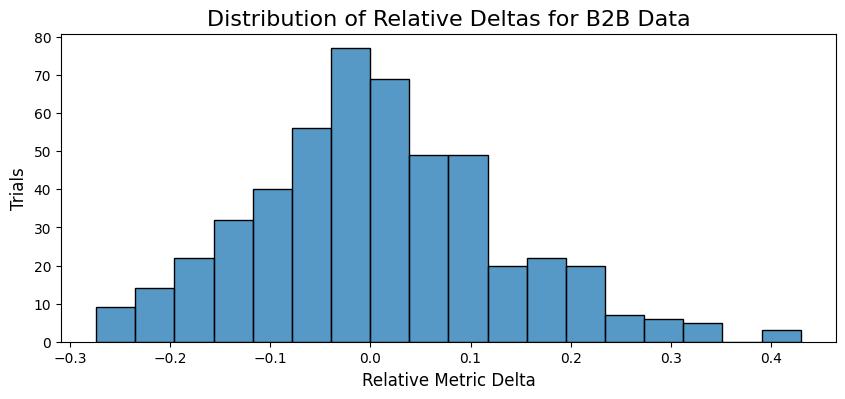

In [ ]:
totals = {
    'HEAD': b2b[b2b['segment'] == 'HEAD'].shape[0],
    'TORSO': b2b[b2b['segment'] == 'TORSO'].shape[0],
    'TAIL': b2b[b2b['segment'] == 'TAIL'].shape[0],
}
salt_threshold = 0.005
def is_salt_balanced(df_s):
  # total_score = 0
  # for segment in ['HEAD', 'TAIL', 'TORSO']:
    # test_ct = df_s[(df_s['group'] == 'test') & (df_s['segment'] == segment)].shape[0]
    # partial_chi = (test_ct - (totals[segment]/2))**2 / totals[segment] +\
    #   (totals[segment]/2 - test_ct)**2 / totals[segment]
    # scaled_partial = partial_chi / math.sqrt(totals[segment])
    # total_score += scaled_partial
  return df_s[(df_s['group'] == 'test') & (df_s['segment'] == 'HEAD')].shape[0]\
     in [math.floor(totals['HEAD']/2), math.ceil(totals['HEAD']/2)]

def run_aa_test_with_stratification(df, outcome_column, unit_column, name, trials=500):
  df_s = df.copy()

  deltas = []
  p_values = []

  for i in range(trials):
    salt_imbalanced = True
    while salt_imbalanced:
      salt = str(uuid.uuid4())
      df_s['group'] = df_s['company_id']\
        .apply(lambda x: 'test' if abs(hash(salt + x)) % 2 == 0 else 'control')
      salt_imbalanced = not is_salt_balanced(df_s)

    df_s['group'] = df_s[unit_column]\
      .apply(lambda x: 'test' if abs(hash(salt + x)) % 2 == 0 else 'control')

    rt = df_s[df_s['group'] == 'test'][outcome_column]
    rc = df_s[df_s['group'] == 'control'][outcome_column]

    deltas.append((np.mean(rt) - np.mean(rc)) / np.mean(rc))
    p_values.append(ttest_ind(rt, rc).pvalue)

  print(f"{100*len([p for p in p_values if p < 0.05])/len(p_values)}% of results were statistically significant false positives\n\n")

  plt.figure(figsize=(10, 4))
  sns.histplot(deltas)
  plt.title(f"Distribution of Relative Deltas for {name} Data", fontsize=16)
  plt.xlabel("Relative Metric Delta", fontsize=12)
  plt.ylabel("Trials", fontsize=12)
  plt.show()


run_aa_test_with_stratification(b2b, 'total_revenue', 'company_id', 'B2B')

In [ ]:
print("For discussion - what risks come with this approach?\n")
print("What is this approach acheiving in practice?")
print(" - Reducing variance?")
print(" - Reducing false discovery rate?")
print(" - Increasing effective power?")

For discussion - what risks come with this approach?

What is this approach acheiving in practice?
 - Reducing variance?
 - Reducing false discovery rate?
 - Increasing effective power?
